In [171]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.figsize"] = (20, 20) #Changes the default size of plotted figures.
import random as rand
from mpl_toolkits.mplot3d import Axes3D

This simulation builds on the strides made in the 2-body and the N-body simulations. It automates the simulation process in three dimensions. While the bodies are primarily moving in 2 dimensions, the goal is to be able to handle movement across three perpendicular axes. I also implement a different color scheme for purely aesthetic purposes. Viewers can extrapolate from the code here for different projects as well. I used Stack Exchange answers to accomplish the change in the default color cycle. I have included their hyperlinks in comments.

In [297]:
#G = 6.674 * 10 ** (-11) * (3600 * 24) ** 2 #m^3 kg^-1 day^-2
G = 6.674 * 10 ** (-11) * (3600 ** 2) #m^3 kg^-1 hr^-2
#G = 6.674 * 10 ** (-11) ##m^3 kg^-1 s^-2


#Standard Distance Equation
def calc_distance(x_position_1 = 0, y_position_1 = 0, z_position_1 = 0, x_position_2 = 0, y_position_2 = 0, z_position_2 = 0): 
    R = np.sqrt((x_position_1 - x_position_2)**2 + (y_position_1 - y_position_2)**2 + (z_position_1 - z_position_2) ** 2)
    return R
#Newtonian equations of motion for velocity and position.
def update_velocity(velocity, acceleration, timestep):
    new_velocity = velocity + (acceleration * timestep)
    return new_velocity      
def update_position(x, y, z, v_x, v_y, v_z, timestep):
    new_x = x + v_x*timestep
    new_y = y + v_y*timestep
    new_z = z + v_z*timestep
    return new_x, new_y, new_z
def calculate_accelerations(bodies):
    x_accelerations = []
    y_accelerations = []
    z_accelerations = []
    for orbitting_body in bodies:
        x_accel = 0
        y_accel = 0
        z_accel = 0
        for central_body in bodies:
            if central_body != orbitting_body:
                R = calc_distance(central_body.x_position, central_body.y_position, central_body.z_position, orbitting_body.x_position, orbitting_body.y_position, orbitting_body.z_position)
                x_accel += -G * central_body.mass * np.abs(R ** (-3)) * (-central_body.x_position + orbitting_body.x_position)
                y_accel += -G * central_body.mass * np.abs(R ** (-3)) * (-central_body.y_position + orbitting_body.y_position)
                z_accel += -G * central_body.mass * np.abs(R ** (-3)) * (-central_body.z_position + orbitting_body.z_position)
        x_accelerations.append(x_accel)
        y_accelerations.append(y_accel)
        z_accelerations.append(z_accel)

    return x_accelerations, y_accelerations, z_accelerations

#The heart of the simulation.


def calculate_step(bodies, t=1):
    for i in range(0, len(bodies)):
        bodies[i].x_position, bodies[i].y_position, bodies[i].z_position = update_position(bodies[i].x_position, bodies[i].y_position, bodies[i].z_position, bodies[i].x_velocity, bodies[i].y_velocity, bodies[i].z_velocity, t)
    x_accelerations, y_accelerations, z_accelerations = calculate_accelerations(bodies)
    for i in range(0, len(bodies)):
        bodies[i].x_velocity = update_velocity(bodies[i].x_velocity, x_accelerations[i], t)
        bodies[i].y_velocity = update_velocity(bodies[i].y_velocity, y_accelerations[i], t)
        bodies[i].z_velocity = update_velocity(bodies[i].z_velocity, z_accelerations[i], t)
    return
        
#generate randomized initial conditions
def generate_initial(bodies):
    for body in bodies:
        time = rand.randint(0, 100)
        print(time)
        i = 0
        while i < time:
            calculate_step([body])
            i+=1
    return 

#Simulation Wrapper: This automates what I did manually in previous works. This code can now take N bodies and handle them
#Computing power allowing, without requiring the user to initialize all of the arrays and appending them.
def simulate(bodies, simulation_time, lim_low = -5 * 10 ** 12, lim_high = 5 * 10 ** 12):
    file = open("simulation.py", "w")
    for body in bodies:
        file.write(body.name + "_x_position = [] \n")
        file.write(body.name + "_y_position = [] \n")
        file.write(body.name + "_z_position = [] \n")
    file.write("for t in range(0, simulation_time): \n")
    for body in bodies:
        file.write("  " + body.name + "_x_position.append(" + body.name + ".x_position) \n")
        file.write("  " + body.name + "_y_position.append(" + body.name + ".y_position) \n")
        file.write("  " + body.name + "_z_position.append(" + body.name + ".z_position) \n")
    file.write("  calculate_step([")
    file.write(bodies[0].name)
    for body in bodies[1:]:
        file.write(", " + body.name)
    file.write("]) \n")

    #Set plot and color configurations
    #Information for changing default color cycle: https://stackoverflow.com/questions/44806598/matplotlib-set-color-cycle-versus-set-prop-cycle
    #https://stackoverflow.com/questions/16006572/plotting-different-colors-in-matplotlib
    file.write("fig = plt.figure() \n")
    file.write("ax = fig.gca(projection = \'3d\')\n")
    file.write("colors = [plt.cm.get_cmap(\'cool\')(i) for i in np.linspace(0, 1, " + str(len(bodies)) + ")]\n")
    file.write("ax.set_prop_cycle('color', colors)\n")
    
    
    for body in bodies:
        file.write("ax.plot(" + body.name + "_x_position, " + body.name + "_y_position, " + body.name + "_z_position, label = \'" + str(body.name) + "\')\n")
    file.write("plt.legend() \n")
    
    
    #Mandate cubic field of view. Make the field of view large enough that the plots are not scrunched together.
    file.write("ax.set_xlim3d(" + str(lim_low) + ", " + str(lim_high) + ")\n")
    file.write("ax.set_ylim3d(" + str(lim_low) + ", " + str(lim_high) + ")\n")
    file.write("ax.set_zlim3d(" + str(lim_low) + ", " + str(lim_high) + ")\n")
    file.write("ax.set_facecolor(\'black\')\n")
    file.write("plt.show() \n")
    file.close()
    exec(open("simulation.py").read()) #Information for running programs within Python programs can be found here: https://stackoverflow.com/questions/7974849/how-can-i-make-one-python-file-run-another
    return
    

    
class body:
    global G
    def __init__(self, name, mass, x_position, y_position, z_position, x_velocity = 0.0, y_velocity = 0.0, z_velocity = 0.0):
        self.name = name
        self.mass = mass
        self.x_position = x_position
        self.y_position = y_position
        self.z_position = z_position
        self.x_velocity = x_velocity
        self.y_velocity = y_velocity
        self.z_velocity = z_velocity

        


In [295]:
#Initial Conditions Values taken from NASA's fact sheets on solar system bodies
#https://nssdc.gsfc.nasa.gov/planetary/planetfact.html

M1 = 1.9091 * 10 ** 30 #kg #solar mass
M2 = 5.9724 * 10 ** 24 #kg #earth mass
M3 = 6.4171 * 10 ** 23 #kg #mars mass
M4 = 3.3011 * 10 ** 23 #kg #mercury mass
M5 = 4.8675 * 10 ** 24 #kg #venus mass
M6 = 1898.19 * 10 ** 24 #kg #Jupiter mass
M7 = 568.34 * 10 ** 24 #kg #Saturn mass
M8 = 86.813 * 10 ** 24 #kg #Uranus mass
M9 = 102.413 * 10 ** 24 #kg #Neptune mass
M10 = 0.01303 * 10 ** 24 #kg #Pluto mass

v_earth = (30.29 * 10 ** 3) * 3600# m/hr max speed
x_earth = 147.09 * 10 ** 9 #m at perihelion
y_earth = 0.0 #m
z_earth = 0.0

v_mars = (26.5 * 10 ** 3) * 3600 #m/hr max speed
x_mars = 206.62 * 10 ** 9 #m at perihelion
y_mars = 0.0
z_mars = 0.0

v_mercury = (58.98 * 10 ** 3) * 3600 #m/hr max speed
x_mercury = 46.0 * 10 ** 9 #m at perihelion
y_mercury = 0.0 #m
z_mercury = 0.0

v_venus = (35.26 * 10 ** 3) * 3600 #m/hr max speed
x_venus = 107.48 * 10 ** 9 #m at perihelion
y_venus = 0.0
z_venus = 0.0

v_jupiter = (13.72 * 10 ** 3) * 3600 #m/hr max speed
x_jupiter = 740.52 * 10 ** 9 #m at perihelion
y_jupiter = 0.0 #m
z_jupiter = 0.0

v_saturn = (10.18 * 10 ** 3) * 3600 #m/hr max speed
x_saturn = 1352.55 * 10 ** 9 #m at perihelion
y_saturn = 0.0
z_saturn = 0.0

v_uranus = (7.11 * 10 ** 3) * 3600 #m/hr max speed
x_uranus = 2741.30 * 10 ** 9 #m at perihelion
y_uranus = 0.0 #m
z_uranus = 0.0

v_neptune = (5.50 * 10 ** 3) * 3600 #m/hr max speed
x_neptune = 4444.45 * 10 ** 9 #m at perihelion
y_neptune = 0.0
z_neptune = 0.0

v_pluto = (6.10 * 10 ** 3) * 3600 #m/hr max speed
x_pluto = 4436.82 * 10 ** 9 #m at perihelion
y_pluto = 0.0 #m
z_pluto = 0.0

Sun = body("Sun", M1, 0.0, 0.0, 0.0, 0.0, 0.0)
Earth = body("Earth", M2, x_earth, y_earth, z_earth, 0.0, v_earth)
Mars = body("Mars", M3, x_mars, y_mars, z_mars, 0.0, v_mars)
Mercury = body("Mercury", M4, x_mercury, y_mercury, z_mercury, 0.0, v_mercury)
Venus = body("Venus", M5, x_venus, y_venus, z_venus, 0.0, v_venus)
Jupiter = body("Jupiter", M6, x_jupiter, y_jupiter, z_jupiter, 0.0, v_jupiter)
Saturn = body("Saturn", M7, x_saturn, y_saturn, z_saturn, 0.0, v_saturn)
Uranus = body("Uranus", M8, x_uranus, y_uranus, z_uranus, 0.0, v_uranus)
Neptune = body("Neptune", M9, x_neptune, y_neptune, z_neptune, 0.0, v_neptune)
Pluto = body("Pluto", M10, x_pluto, y_pluto, z_pluto, 0.0, v_pluto)



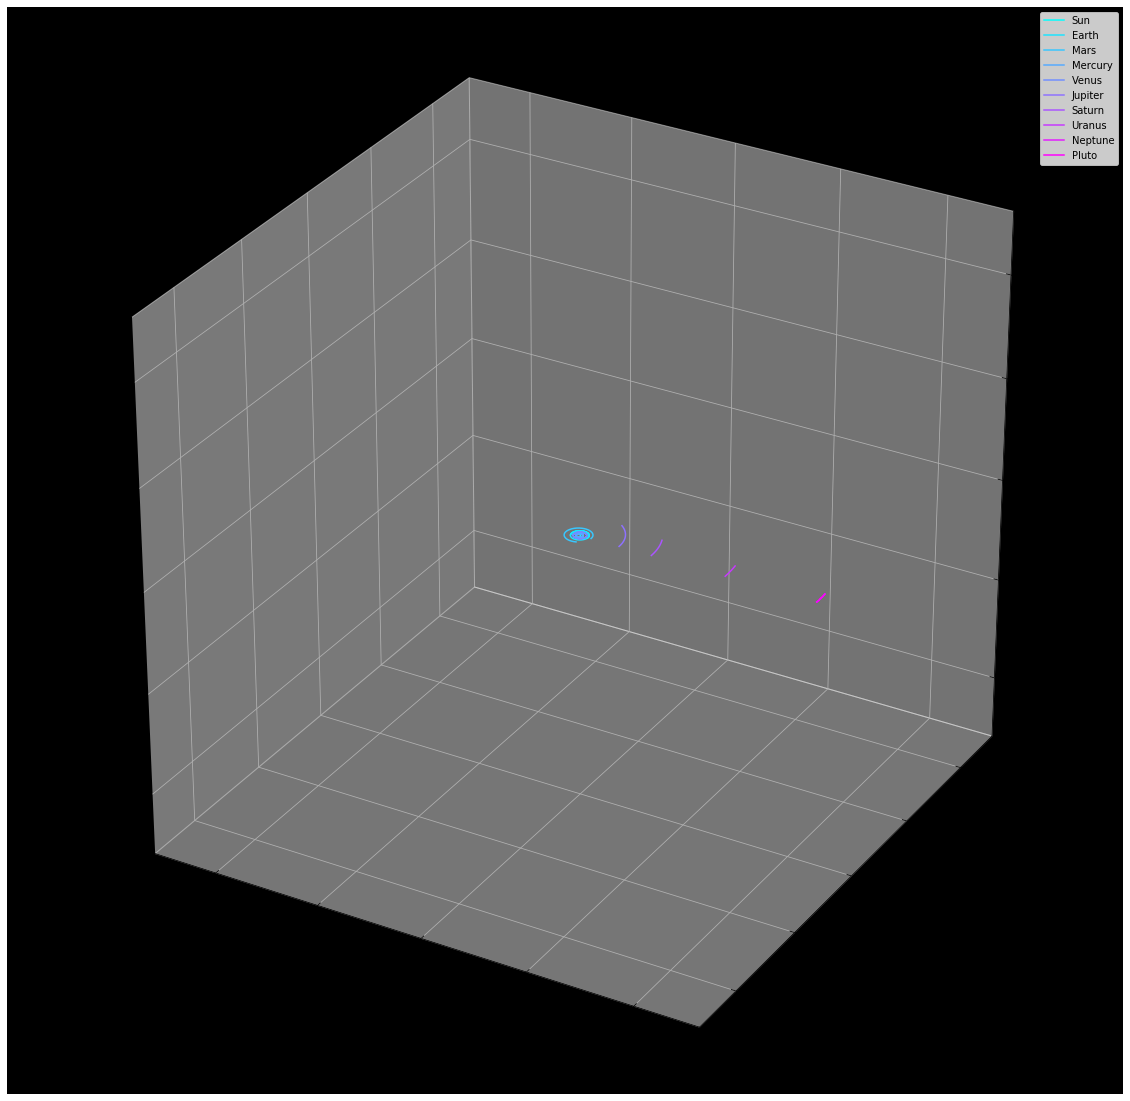

In [296]:
bodies = [Sun, Earth, Mars, Mercury, Venus, Jupiter, Saturn, Uranus, Neptune, Pluto]
simulation_time = 15000
simulate(bodies, simulation_time)